## Predicting the Presence of Kidney Stone through a Urine Test

This dataset comes from Kaggle at "https://www.kaggle.com/datasets/harshghadiya/kidneystone" and provides data that can be used to predict the presence or likelyhood of Kidney Stone given the result parameters of a Urine test.

The dataset has the following features.

- No name: Refers to the row number or patient ID. 
- gravity: Specific gravity of urine, which is a measure of its density compared to the density of water. It can be affected by various factors, such as hydration level, diet, and medical conditions.
- ph: The level of acidity or alkalinity of urine. The pH scale ranges from 0 to 14, with a pH of 7 being neutral. A pH value below 7 is acidic, while a pH value above 7 is alkaline.
- osmo: Osmolality is a measure of the concentration of dissolved particles in urine. It can be used to evaluate the kidney's ability to concentrate or dilute urine.
- cond: Conductivity is a measure of the ability of a solution to conduct electrical current. It can be affected by the concentration of dissolved ions in urine.
- urea: Urea is a waste product that is formed in the liver from the breakdown of proteins. It is excreted by the kidneys in urine and can be used to evaluate kidney function.
- calc: Calcium is a mineral that is important for bone health and other body functions. It is excreted in urine and can be used to evaluate kidney function and calcium metabolism.
- target: This is the target variable that indicates whether the patient has kidney stones or not. It is a binary variable with a value of 1 indicating the presence of kidney stones and a value of 0 indicating the absence of kidney stones.

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import statsmodels.formula.api as smf

path = "kidney-stone-dataset.csv"
df = pd.read_csv(path)

## Data

In [76]:
print("----- Dataframe Info -----")
df.info()


----- Dataframe Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  90 non-null     int64  
 1   gravity     90 non-null     float64
 2   ph          90 non-null     float64
 3   osmo        90 non-null     int64  
 4   cond        90 non-null     float64
 5   urea        90 non-null     int64  
 6   calc        90 non-null     float64
 7   target      90 non-null     int64  
dtypes: float64(4), int64(4)
memory usage: 5.8 KB


In [77]:
print("\n----- Null counts -----")
null_counts = df.isna().sum()
print(null_counts)


----- Null counts -----
Unnamed: 0    0
gravity       0
ph            0
osmo          0
cond          0
urea          0
calc          0
target        0
dtype: int64


Inspecting the data: 
- The column 'target' will be the target it has values of 0 or 1. 0 determing a negative result for kidney stone and 1 for a positive result.
- There are 8 columns with 7 useful features (Unamed: 0 is a patient ID).
- There are 90 observations in the entire dataset. This isn't a huge number of observations and could lead to the issue of overfitting later. 
- How many features have null values? It appears there are no null values in the dataset and no cleaning of data is required. We should remove the column 'Unnamed: 0' as it provides no benefit towards predictions is a purely an ID.

In [78]:
df.drop('Unnamed: 0',axis=1,inplace=True)
clean_df = df.copy()

## EDA

Can start off by getting an idea of the distribution of the data for each feature and pair-wise relationships. 

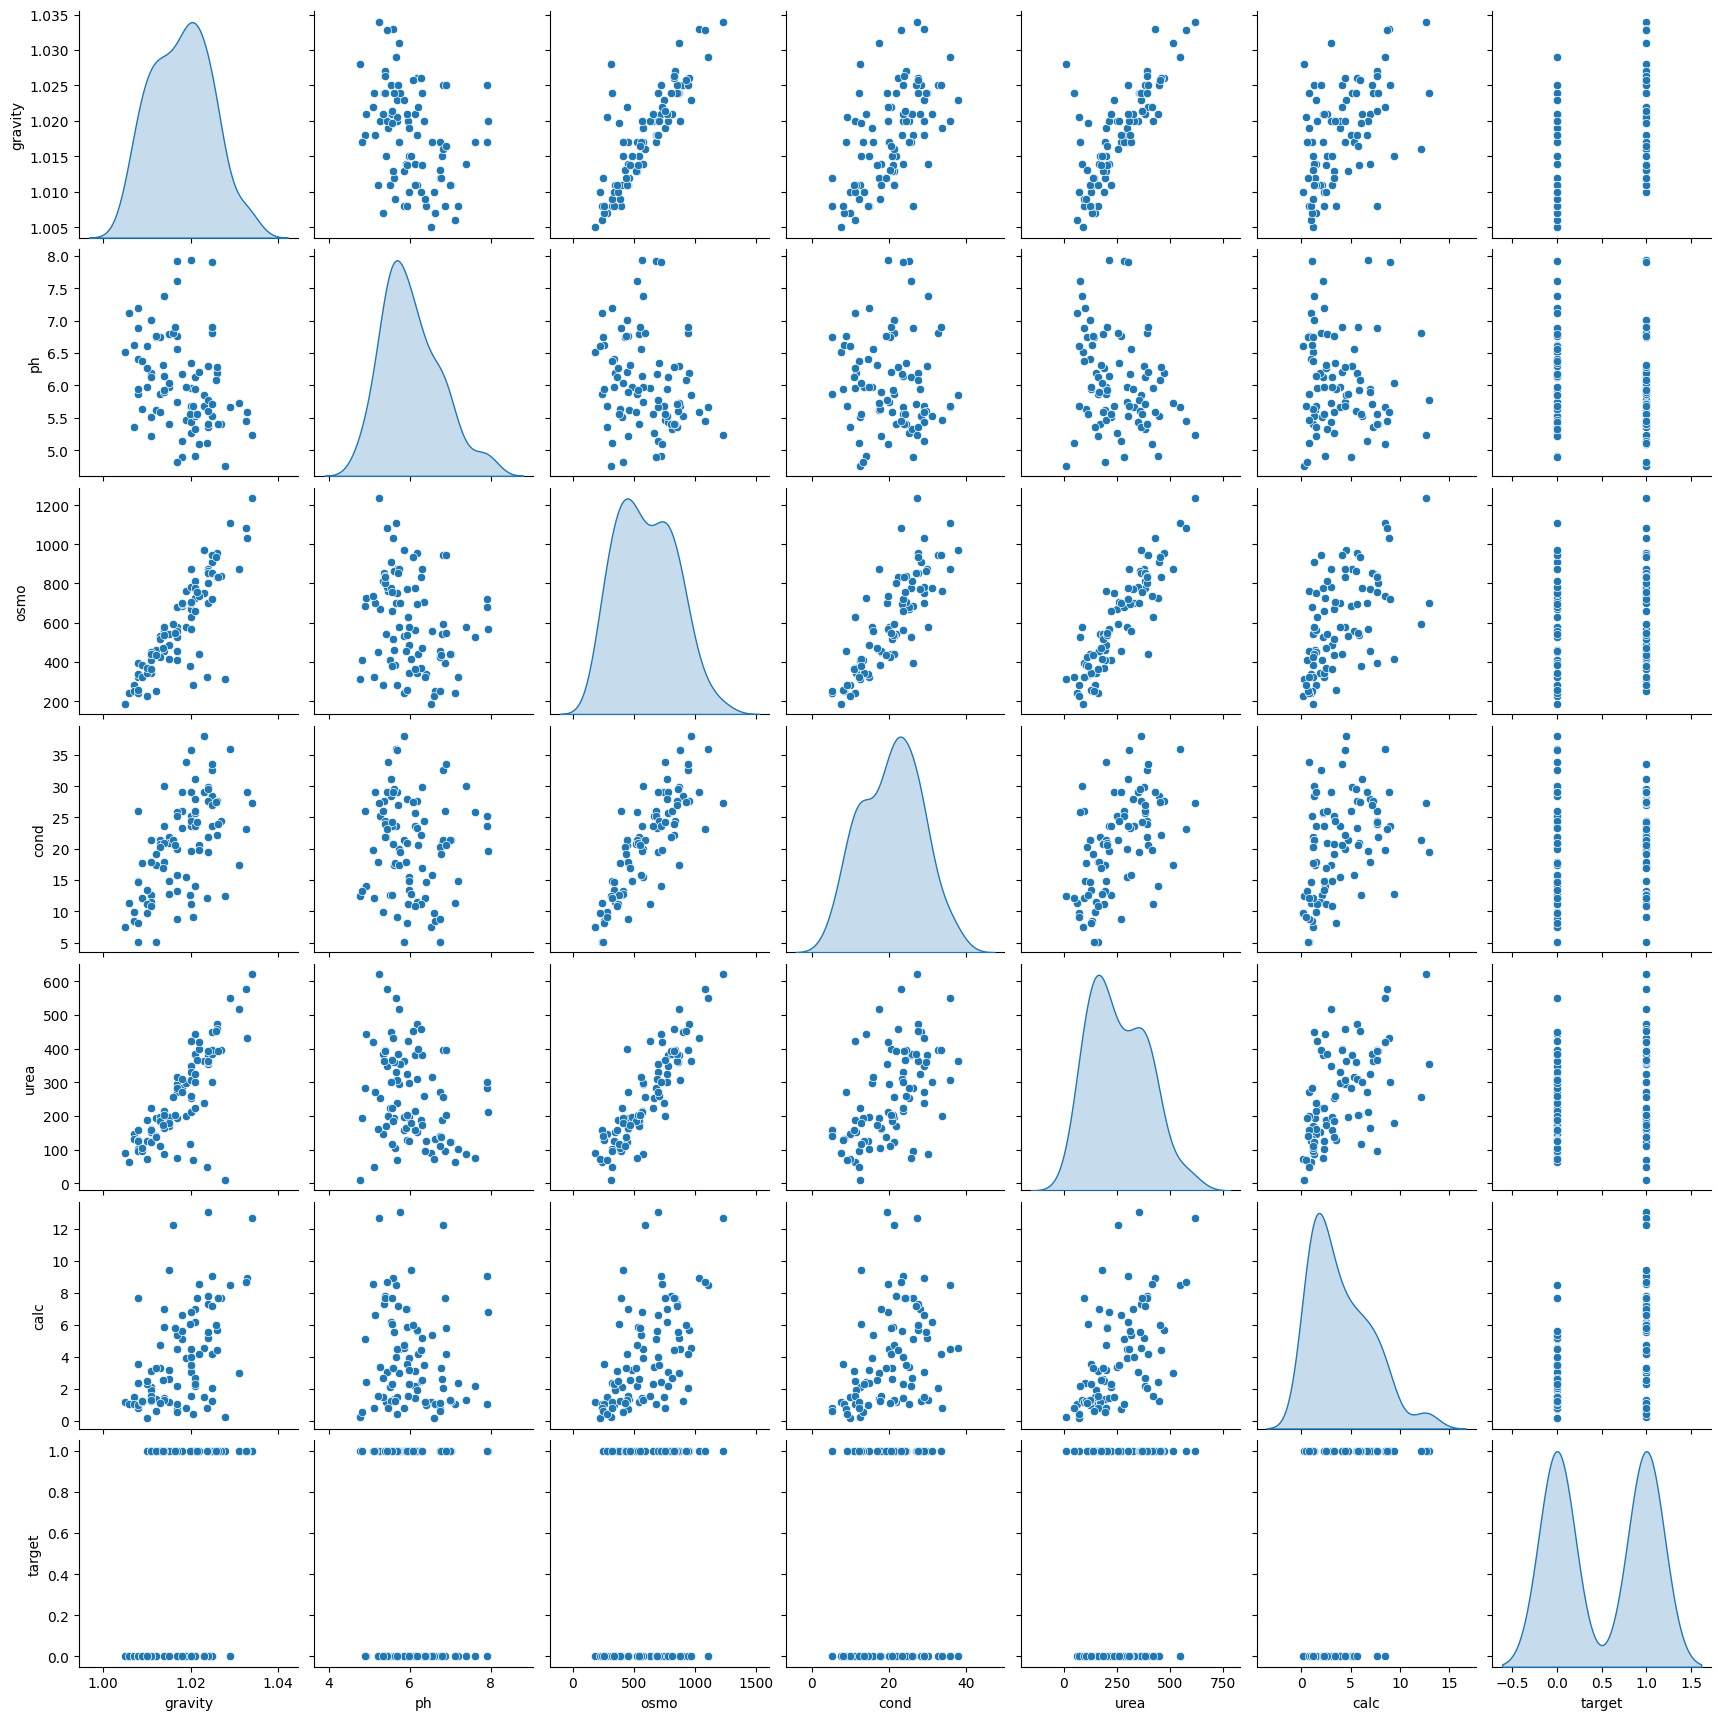

In [79]:
sns.pairplot(clean_df[list(clean_df.columns)], diag_kind='kde')


Looking at the diagonal entries we can see the distribution of data for each feature. All features except for target have a unimodel peak with distinct mean and standard deviation. There is limited skewness in the features except for 'calc'. Should be noted that the bimodel peaks seen in the 'target' feature show an exact even distribution for a positive or negative result for kidney stones.

There is no negative correlation between feature pairs. 

There is positive correlation between the following feature pairs. 
- gravity and urea (strong)
- gravity and cond 
- gravity and osmo (strong)
- osmo and urea (strong)
- osmo and cond (strong)

The following positive correlating features have a tight linear distribution indicating a colinear relationship.
- gravity and urea (strong)
- gravity and osmo (strong)
- osmo and urea (strong)
- osmo and cond (strong)

Given these collinear and strong correlating relationships between the pairs. It likely this will cause problems with linear regression by overfitting the data. An approach would be to remove a particular feature such as 'gravity' or 'osmo' in this situation. Given my knowledge of what is important in a urine test (none) a later approach would be to build a model that can handle a more generalized prediction such as a tree. 

A correlation matrix can also be used to determine a quanitative measure of the positive/negative correlation between two features.

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

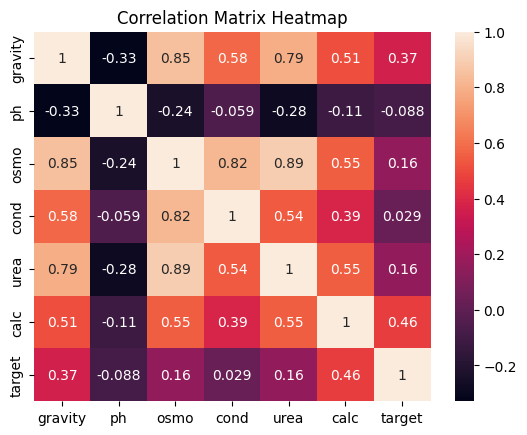

In [80]:
corr_matrix = clean_df.corr()

plt.figure()
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap')

A strong positive correlation can be seen here again with a few pairs.
- gravity and osmo
- gravity and urea 
- osmo and cond

This actually agrees with the strong positive correlation seen in the pairplot above but given we now have a quantative measure and have seen the distribution. It is highly likely that we have a few pairs that are not just strongly correlated but also collinear.

In multiple regression analysis, multicollinearity can distort the results and interpretation. We can use variance inflation factor (VIF) to further detect multicollinearity during EDA.

In [81]:
# Separate predictor variables (X) and dependent variable (Y)
df = clean_df.copy()
X = df.drop('target', axis=1)
Y = df['target']

# Add a constant to the predictor variables matrix for the regression intercept
X = sm.add_constant(X)

# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)


  Variable            VIF
0    const  102454.007268
1  gravity       4.557866
2       ph       1.166381
3     osmo      34.353472
4     cond       8.047657
5     urea      11.131125
6     calc       1.490121


Interpretation of VIF values:

A VIF of 1 indicates no multicollinearity between the predictor variable and the other predictor variables.
A VIF between 1 and 5 usually suggests moderate multicollinearity.
A VIF greater than 5 or 10 (thresholds may vary) indicates high multicollinearity.

From the above we can see 'osmo' and 'urea' have high multicollinearity.

## Models

Given the strong multicollinear relationships present in the dataset. Linear and multi-linear regression models are likely to produce unstable and unreliable coefficient estimates. Ie. When predictor variables are highly correlated, it becomes difficult for the model to determine the individual contribution of each predictor to the dependent variable. As a result, the estimated regression coefficients can become highly sensitive to small changes in the data, leading to unstable and unreliable estimates.

However we can try to reduce the affects by removing a feature or combining one more features.

In [82]:
# Separate predictor variables (X) and dependent variable (Y)
regression_df = clean_df.copy()
regression_df.drop(["osmo"], axis=1, inplace=True)
X = regression_df.drop('target', axis=1)
Y = regression_df['target']

# Add a constant to the predictor variables matrix for the regression intercept
X = sm.add_constant(X)

# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)


  Variable           VIF
0    const  70170.471866
1  gravity      3.100508
2       ph      1.166146
3     cond      1.603489
4     urea      2.982295
5     calc      1.485959


After removing 'osmo' there does not appear to be a large collinear relationship anymore. So let proceed with linear regression.

In [83]:
X_train, X_test = train_test_split(regression_df, test_size=0.2, random_state=42)

formula = 'target ~ gravity + ph + cond + urea + calc'
model_multi = smf.ols(formula, data=X_train).fit()
print(f"Adjusted R^2 multi_model Model {model_multi.rsquared_adj:0.4}", )

Adjusted R^2 multi_model Model 0.3611


Now lets fit construct to model again with features that are statically significant p <= 0.05. We can see that 'ph' and 'cond' could be removed.

In [84]:
X_train, X_test = train_test_split(regression_df, test_size=0.2, random_state=42)

# Construct formula for the model
formula = 'target ~ gravity + ph + cond + urea + calc'

# Fit the model
model_multi_backwards_elimination = smf.ols(formula=formula, data=regression_df).fit()
# perform backward elimination
while model_multi_backwards_elimination.pvalues.max() > 0.05:
    # find the feature with the highest p-value
    feature_to_remove = model_multi_backwards_elimination.pvalues.idxmax()
    # remove the feature from the formula
    formula = formula.replace(f' + {feature_to_remove}', '')
    formula = formula.replace(f'{feature_to_remove} + ', '')
    formula = formula.replace(f'{feature_to_remove}', '')
    # fit the model again with the reduced formula
    model_multi_backwards_elimination = smf.ols(formula=formula, data=regression_df).fit()
print(f"Adjusted R^2 model_multi_backwards_elimination Model {model_multi_backwards_elimination.rsquared_adj:0.4}", )

Adjusted R^2 model_multi_backwards_elimination Model 0.3608


An adjusted R^2 value of 0.36 is not great and it is probably worth trying a different kind of model. Logistic regression could be used but suffers from the same drawback as a linear regression model with collinear features. 

Instead a decision tree can help address some of the issues we face with a multiple linear regression model that has collinear features. It would not be affected by multicollinearity because they don't rely on linear combinations of features. They make splits based on individual features, and the presence of collinear features does not affect the tree's ability to make accurate predictions.

In [85]:
# Split the data into training and testing sets
dt_df = clean_df.copy()
y = dt_df["target"]
X = dt_df.drop(["target"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Create the decision tree classifier
simple_dtc = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
simple_dtc.fit(X_train, y_train)

# Predict the target values for the test data
y_pred = simple_dtc.predict(X_test)

# Evaluate the performance of the classifier
simple_dtc_accuracy = accuracy_score(y_test, y_pred)
simple_dtc_recall = recall_score(y_test, y_pred)
simple_dtc_conf_matrix = confusion_matrix(y_test, y_pred)
simple_dtc_f1_score = f1_score(y_test, y_pred)
simple_dtc_roc_auc_score = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {simple_dtc_accuracy:0.4f}")
print(f"Recall: {simple_dtc_recall:0.4f}")
print(f"Confusion Matrix:\n {simple_dtc_conf_matrix}")
print(f"F1 Score: {simple_dtc_f1_score}")
print(f"ROC AUC Score: {simple_dtc_roc_auc_score}")


Accuracy: 0.7778
Recall: 0.8333
Confusion Matrix:
 [[9 3]
 [1 5]]
F1 Score: 0.7142857142857143
ROC AUC Score: 0.7916666666666666


Let's see if the model can be improved by tuning the hyper parameters of the maximum tree depth and maximum leaf node count.

In [86]:
dt_df = clean_df.copy()
y = dt_df["target"]
X = dt_df.drop(["target"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Define the hyperparameter grid to search over
param_grid = {
    "max_depth": list(range(1, 5)),
    "max_leaf_nodes": list(range(2, 10))
}

best_score = 0.0
best_params = {}
for k in range(2, 10):
    # Perform a grid search with 5-fold cross-validation
    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=k, scoring="accuracy")
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters and the corresponding mean cross-validated score
    if grid_search.best_score_ >= best_score:
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
    
# Train a new classifier with the best hyperparameters on the full training set
tuned_hyperparams_dtc = DecisionTreeClassifier(random_state=42, max_depth=best_params["max_depth"], max_leaf_nodes=best_params["max_leaf_nodes"])
tuned_hyperparams_dtc.fit(X_train, y_train)

# Evaluate the performance of the best classifier on the test set
y_pred = tuned_hyperparams_dtc.predict(X_test)
tuned_hyperparams_dtc_accuracy = accuracy_score(y_test, y_pred)
tuned_hyperparams_dtc_recall = recall_score(y_test, y_pred)
tuned_hyperparams_dtc_conf_matrix = confusion_matrix(y_test, y_pred)
tuned_hyperparams_dtc_f1_score = f1_score(y_test, y_pred)
tuned_hyperparams_dtc_roc_auc_score = roc_auc_score(y_test, y_pred)

# Print the results
print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validated accuracy: {best_score:.2f}")
print(f"Accuracy on test set: {tuned_hyperparams_dtc_accuracy:.2f}")
print(f"Recall on test set: {tuned_hyperparams_dtc_recall:.2f}")
print(f"Confusion Matrix:\n {tuned_hyperparams_dtc_conf_matrix}")
print(f"F1 Score: {tuned_hyperparams_dtc_f1_score}")
print(f"ROC AUC Score: {tuned_hyperparams_dtc_roc_auc_score}")

Best hyperparameters: {'max_depth': 4, 'max_leaf_nodes': 5}
Best cross-validated accuracy: 0.81
Accuracy on test set: 0.67
Recall on test set: 0.50
Confusion Matrix:
 [[9 3]
 [3 3]]
F1 Score: 0.5
ROC AUC Score: 0.625


Let's have a look at how a Random Forest Classifier would perform.

In [87]:
dt_df = clean_df.copy()
y = dt_df["target"]
X = dt_df.drop(["target"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Create the random forest classifier
rfc = RandomForestClassifier(n_estimators=50, random_state=42)

# Fit the classifier to the training data
rfc.fit(X_train, y_train)

# Predict the target values for the test data
y_pred = rfc.predict(X_test)

# Evaluate the performance of the classifier
rfc_accuracy = accuracy_score(y_test, y_pred)
rfc_recall = recall_score(y_test, y_pred)
rfc_conf_matrix = confusion_matrix(y_test, y_pred)
rfc_f1_score = f1_score(y_test, y_pred)
rfc_roc_auc_score = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {rfc_accuracy:0.4f}")
print(f"Recall: {rfc_recall:0.4}")
print(f"Confusion Matrix:\n {rfc_conf_matrix}")
print(f"F1 Score: {rfc_f1_score}")
print(f"ROC AUC Score: {rfc_roc_auc_score}")

Accuracy: 0.7778
Recall: 0.8333
Confusion Matrix:
 [[9 3]
 [1 5]]
F1 Score: 0.7142857142857143
ROC AUC Score: 0.7916666666666666


## Results and Analysis

In [88]:
print(f"Adjusted R^2 Multi-variable Model {model_multi.rsquared_adj:0.4}", )
print(f"Adjusted R^2 Multi-variable Model with Backwards Elimination {model_multi_backwards_elimination.rsquared_adj:0.4}")

Adjusted R^2 Multi-variable Model 0.3611
Adjusted R^2 Multi-variable Model with Backwards Elimination 0.3608


An adjusted R^2 value of 0.3608 indicates that the model explains about 36% of the variance in the target variable (positive or negative result for kidney stones). While this may seem relatively low, it is not uncommon to have a low R^2 value in medical data where there are many factors that contribute to the outcome.

As for the tree based models. Looking at the accuracy, recall, f1 score and roc auc score. 

['Accuracy', 'Recall', 'F1 Score', 'ROC AUC']
simple_dtc_scores: [0.7777777777777778, 0.8333333333333334, 0.7142857142857143, 0.7916666666666666]
tuned_dtc_scores: [0.6666666666666666, 0.5, 0.5, 0.625]
rfc_scores: [0.7777777777777778, 0.8333333333333334, 0.7142857142857143, 0.7916666666666666]


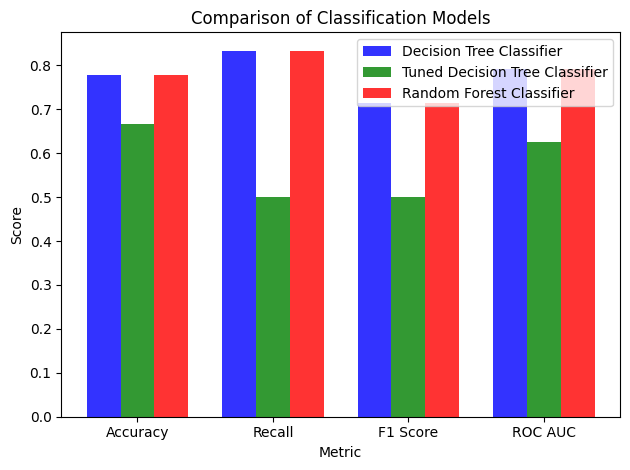

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics to compare
metrics = ['Accuracy', 'Recall', 'F1 Score', 'ROC AUC']
simple_dtc_scores = [simple_dtc_accuracy, simple_dtc_recall, simple_dtc_f1_score, simple_dtc_roc_auc_score]
tuned_dtc_scores = [tuned_hyperparams_dtc_accuracy, tuned_hyperparams_dtc_recall, tuned_hyperparams_dtc_f1_score, tuned_hyperparams_dtc_roc_auc_score]
rfc_scores = [rfc_accuracy, rfc_recall, rfc_f1_score, rfc_roc_auc_score]
print(f"{metrics}")
print(f"simple_dtc_scores: {simple_dtc_scores}")
print(f"tuned_dtc_scores: {tuned_dtc_scores}")
print(f"rfc_scores: {rfc_scores}")
# Set up the plot
fig, ax = plt.subplots()
index = np.arange(len(metrics))
bar_width = 0.25
opacity = 0.8

# Plot the bars for each model
rects1 = ax.bar(index, simple_dtc_scores, bar_width,
                alpha=opacity, color='b', label='Decision Tree Classifier')
rects2 = ax.bar(index + bar_width, tuned_dtc_scores, bar_width,
                alpha=opacity, color='g', label='Tuned Decision Tree Classifier')
rects3 = ax.bar(index + 2*bar_width, rfc_scores, bar_width,
                alpha=opacity, color='r', label='Random Forest Classifier')

# Set the labels and title
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Classification Models')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics)
ax.legend()
plt.tight_layout()


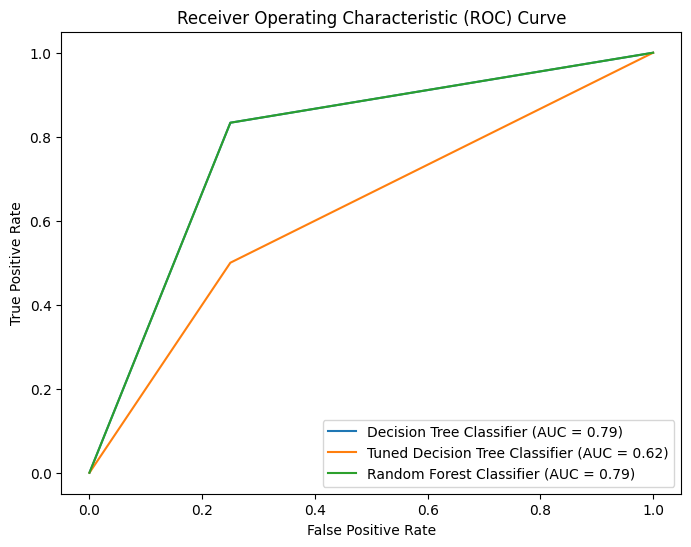

In [90]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Plot ROC curve for simple DTC
simple_dtc_y_pred = simple_dtc.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, simple_dtc_y_pred)
roc_auc = roc_auc_score(y_test, simple_dtc_y_pred)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=simple_dtc_roc_auc_score, estimator_name='Decision Tree Classifier')
display.plot(ax=ax, name='Decision Tree Classifier')

# Plot ROC curve for tuned hyperparameters DTC
tuned_hyperparams_dtc_y_pred = tuned_hyperparams_dtc.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, tuned_hyperparams_dtc_y_pred)
roc_auc = roc_auc_score(y_test, tuned_hyperparams_dtc_y_pred)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=tuned_hyperparams_dtc_roc_auc_score, estimator_name='Tuned Decision Tree Classifier')
display.plot(ax=ax, name='Tuned Decision Tree Classifier')

# Plot ROC curve for RFC
rfc_y_pred = rfc.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, rfc_y_pred)
roc_auc = roc_auc_score(y_test, rfc_y_pred)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=rfc_roc_auc_score, estimator_name='Random Forest Classifier')
display.plot(ax=ax, name='Random Forest Classifier')

# Set the title and labels for the plot
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# Show the legend
ax.legend()

# Display the plot
plt.show()


It appears that the Tuned Decision Tree Classifier has the worst performance in all aspects in comparison to the Decision Tree Classifier and Random Forest Classifier. 

This could be that the Tuned Decision Tree Classifier model might be overfitting on the training data due to the hyperparameters being optimized for the training data. This could cause the model to perform poorly on the test data. Or the Tuned Decision Tree Classifier model might not have been tuned optimally, resulting in suboptimal hyperparameters being chosen. This could lead to decreased performance on the test data compared to the other models.

The Random Forest Classifier (RFC) is a variant of decision tree algorithms that builds multiple decision trees by selecting a subset of features at random and taking the average prediction of each decision tree. RFC has several advantages over a regular decision tree, such as reducing overfitting and increasing the model's stability.

However, in some cases, the subset of features selected by RFC may not differ significantly from the features selected by a regular decision tree, resulting in similar performance. This could be the reason why the RFC has the same performance as the untuned Decision Tree Classifier in this case.


## Discussions and Conclusions

Some of the key takeaways and learnings from the analysis of the three classifier models:

- Decision Tree Classifier (simple): The simple decision tree classifier has a good performance with an accuracy of 0.77 and recall of 0.83. The AUC score is 0.79, which indicates that the model is able to distinguish between positive and negative cases with moderate accuracy.

- Decision Tree Classifier (tuned): The tuned decision tree classifier had a slightly lower performance than the other models. This could be due to the overtuning occuring from the hyper parameter tuning.

- Random Forest Classifier: The random forest classifier (RFC) has a good performance among the three models much like the simple decision tree classifier, with an accuracy of 0.77, recall of 0.83, and AUC score of 0.79. The random forest classifer is meant to overcome overfitting and also increase the model's stability. However there is a chance the subset of features selected by RFC may not differ significantly from the features selected by a regular decision tree, resulting in similar performance.

Some aspects that didn't work: 

- The multi-variable linear regression model did not perform well due to the high correlation between features and collinearity between a number of the features. Even after removing collinearity by removing a feature and further improving the statistic significance of the features. The model could only account for 37% of the variance in the training data. 

- It was expected that the classifier models performance metrics would slowly improve going from a simple decision tree classifier to tuned decision tree classifier and finally the random forest classifier. However the ranking was quite different and there was no improvement from the simple decision tree classifier.

Suggestions to Improve:

There are several ways to improve the results of a machine learning model on a small dataset with correlated features:

- Collect more data: Collecting more data can help to reduce overfitting and increase the accuracy of the model. However, this may not always be possible or practical.

- Feature selection and engineering: Irrelevent or redundent features were removed but the combination of multiples features was never tried.

- Try different models: Experiment with different types of models, such as support vector machines, or neural networks. 

- Cross-validation: Using cross-validation techniques can help to evaluate the performance of the model and prevent overfitting. It involves splitting the data into training and testing sets multiple times and evaluating the model's performance on each split.





